# $X^2$ for the Sodium Data
I read through chapter 12 in An Introduction to Error Analysis (Taylor, 2nd ed) that covers $X^2$.  He calls dividing it by the degrees of freedom the reduced $X^2$, or $\tilde{X^2}$.  I used four points, the two from the Cs-137, and two from Co-60 and did a linear regression on that to get a line.  Then 

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [39]:
df = pd.read_csv('data/peaks/uncalibrated_peaks.csv')
df.head()

,detector,element,ROI_Start,ROI_End,Gross,Net,Centroid,FWHM,Known_keV
0,ge,bg,32,35,4093,104,33,--,NaN
1,ge,bg,39,43,21079,12163,40,--,NaN
2,ge,bg,151,154,4259,1189,152,--,NaN
3,ge,bg,165,170,9392,6865,167,2,NaN
4,ge,bg,193,199,23971,-3679,198,--,NaN


In [40]:
# Getting the non-null values for cs137 and co60
#na_cal = df[(df['detector']=='na') & (df['Known_keV'].isna() == False)].sort_values(['detector', 'ROI_Start']).copy()
ge_cal = df[(df['detector']=='ge') & (df['Known_keV'].isna() == False)].sort_values(['detector', 'ROI_Start']).copy()
na_cal = ge_cal
na_cal

,detector,element,ROI_Start,ROI_End,Gross,Net,Centroid,FWHM,Known_keV
15,ge,cs137,20,32,3175,821,26,8,32.0
19,ge,cs137,391,403,13418,13265,398,3,661.7
49,ge,co60,702,709,8800,7819,704,3,1173.2
50,ge,co60,795,804,7538,7022,801,3,1332.5


In [41]:
# Converting FWHM to a number
na_cal['FWHM'] = na_cal['FWHM'].astype(np.float64)
na_cal.dtypes

detector      object
element       object
ROI_Start      int64
ROI_End        int64
Gross          int64
Net            int64
Centroid       int64
FWHM         float64
Known_keV    float64
dtype: object

In [42]:
# Getting the values to fit into a linear model
x = na_cal[['Centroid']]
y = na_cal[['Known_keV']]

In [43]:
# Using scikit-learn to fit a linear regression
model = LinearRegression()
model.fit(x, y)

# Now getting the prediction of the model, using the x as input again
y_hat = model.predict(x)

In [44]:
x.to_numpy()

array([[ 26],
       [398],
       [704],
       [801]], dtype=int64)

In [45]:
# Computing the y-errors, FWHM is 2.355 * sigma, so converting
# it to sigma and then multiplying by two for my error.  So +/- 2 sigma
# is a reasonable error.
na_cal['yerr'] = round(na_cal['FWHM'] / 2.355 * 2, 0)
na_cal

,detector,element,ROI_Start,ROI_End,Gross,Net,Centroid,FWHM,Known_keV,yerr
15,ge,cs137,20,32,3175,821,26,8.0,32.0,7.0
19,ge,cs137,391,403,13418,13265,398,3.0,661.7,3.0
49,ge,co60,702,709,8800,7819,704,3.0,1173.2,3.0
50,ge,co60,795,804,7538,7022,801,3.0,1332.5,3.0


In [46]:
na_cal['yerr'].shape


(4,)

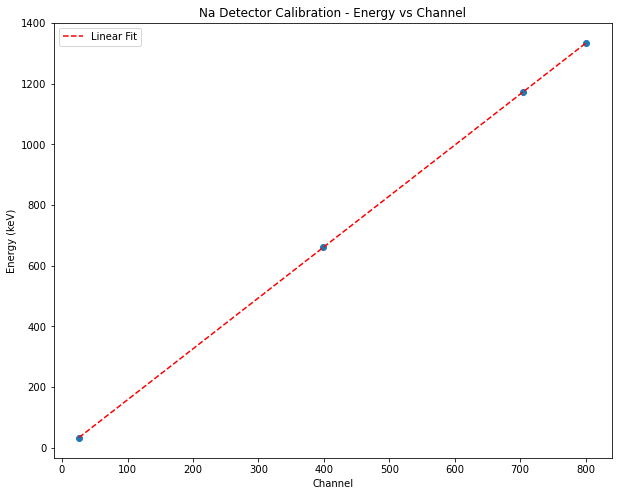

In [47]:
plt.figure(figsize=(10,8))
plt.scatter(x,y)
#plt.plot(x, y_hat, linestyle='--', color='r', label='Linear Fit')
plt.plot(x.to_numpy(), y_hat, linestyle='--', color='r', label='Linear Fit')
#plt.errorbar(x.to_numpy(), y.to_numpy(), yerr=na_cal['yerr'].to_numpy(), fmt='none', capsize=10)
#plt.errorbar(x, y, yerr=5, fmt='none', capsize=10)
plt.legend()
plt.title('Na Detector Calibration - Energy vs Channel')
plt.xlabel('Channel')
plt.ylabel('Energy (keV)')
plt.show()

**Note**: The errorbar function gave me problems re-running it this morning so I've commented it out until I can fix it.  That plot function more than any other is extremely sensitive to the dimensions of the values passed to it and can't seem to logically broadcast things like every other plotting function I've used.

## Computing $\tilde{X}^2$
The reduced $X^2$, which is just $\tilde{X}^2 = \frac{X^2}{N-c}$, where $c$ is the constraints, so $N-c$ is the degrees of freedom.

For this we're doing a linear fit so we have two parameters, slope and intercept, and four points.  So the degrees of freedom is $2$, just $4-2$.

$$\tilde{X}^2 = \frac{1}{N-c}\sum^{N}_{k=1}\left(\frac{O_k - E_k}{\sigma_k}\right)^2$$

Where $O_k$ is the observation, and $E_k$ is the expected value, and of course $\sigma_k$ is the error in the expected value.  In this case $\sigma_k$ is just the FWHM divided by 2.355 to get it as a standard deviation, and then multiplied by 2 so it should be within two standard deviations (95% chance).  The observation is what we measured for the energy, and the expected value is what our linear fit says it should actually be ($\hat{y}$)

In [48]:
# Compute & sum all of these terms
1/2 * (((y.to_numpy() - y_hat)/na_cal[['yerr']].to_numpy())**2).sum()

1.0486364054587598

So I get a $\tilde{X}^2$ of 1.04, basically 1.0 on the nose and this seems like a good fit.